In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
from midiutil import MIDIFile
from scipy import stats as st
from scipy.ndimage import uniform_filter1d
import os

# Encontrar una región "plana" en el espectro

Este primer código busca una región plana dentro del espectro parándose en un punto y mirando n puntos alrededor de ese punto la media y la desviación de esa región, la región que tenga media entre 0.95 y 1.05 se selecciona y se calcula su desviación, si la desviación en esa región es menor que la mitad de la mediana se selecciona como región plana. 

Todo esto se realiza posterior a realizar un suavizado a los datos con el fin de evitar ruidos y encontrar mejor la región "plana" para tomar su media

In [2]:
def detectar_region_plana(archivo, ventana=100, suavizado=10, rango_central=(0.95, 1.05)):
    
    # Cargar datos
    with open(archivo, 'r') as f:
        primera_linea = f.readline().strip()
    
    # Detectar si hay encabezado
    try:
        [float(x) for x in primera_linea.split()]
        skip = 0  # No es encabezado
    except ValueError:
        skip = 1  # Es encabezado

    # Intentar leer con diferentes separadores
    try:
        datos = pd.read_csv(archivo, sep=r"\s+", comment='#', header=None, skiprows=skip, dtype={0: float, 1: float})
    except:
        datos = pd.read_csv(archivo, sep=';', comment='#', header=None, skiprows=skip, dtype={0: float, 1: float})

    
    longitudes_onda = datos.iloc[:, 0].values
    intensidades = datos.iloc[:, 1].values
    
    # Aplicar suavizado si es necesario
    if suavizado > 1:
        intensidades_suavizadas = uniform_filter1d(intensidades, size=suavizado)
    else:
        intensidades_suavizadas = intensidades
    
    # Calcular la media y desviación estándar en ventanas móviles
    medias = np.array([np.mean(intensidades_suavizadas[i:i+ventana]) for i in range(len(intensidades_suavizadas) - ventana)])
    stds = np.array([np.std(intensidades_suavizadas[i:i+ventana]) for i in range(len(intensidades_suavizadas) - ventana)])
    
    # Filtrar regiones que estén dentro del rango dado
    indices_planos = np.where((medias >= rango_central[0]) & (medias <= rango_central[1]) & (stds < np.median(stds) * 0.5))[0]
    
    if len(indices_planos) == 0:
        print("No se encontró una región plana con los criterios dados.")
        return None
    
    # Seleccionar la primera región plana detectada
    idx_mejor_region = indices_planos[0]
    mejor_media = medias[idx_mejor_region]
    mejor_std = stds[idx_mejor_region]
    region_x = longitudes_onda[idx_mejor_region:idx_mejor_region+ventana]
    region_y = intensidades[idx_mejor_region:idx_mejor_region+ventana]
    
    return mejor_media, mejor_std

### Este código de abajo es lo mismo que el de arriba solo que se agrega gráfica para verificar funcionamiento, pero el de arriba es el que se utiliza en los códigos de sonificación para evitar problemas con graficaciones

In [3]:
def detectar_region_plana_grafica(archivo, ventana=10, rango_central=(0.95, 1.05), suavizado=5):
    # Cargar datos
    with open(archivo, 'r') as f:
        primera_linea = f.readline().strip()
    
    # Detectar si hay encabezado
    try:
        [float(x) for x in primera_linea.split()]
        skip = 0  # No es encabezado
    except ValueError:
        skip = 1  # Es encabezado

    # Intentar leer con diferentes separadores
    try:
        datos = pd.read_csv(archivo, sep=r"\s+", comment='#', header=None, skiprows=skip, dtype={0: float, 1: float})
    except:
        datos = pd.read_csv(archivo, sep=';', comment='#', header=None, skiprows=skip, dtype={0: float, 1: float})

    longitudes_onda = datos.iloc[:, 0].values
    intensidades = datos.iloc[:, 1].values
    
    # Aplicar suavizado si es necesario
    if suavizado > 1:
        intensidades_suavizadas = uniform_filter1d(intensidades, size=suavizado)
    else:
        intensidades_suavizadas = intensidades
    
    # Calcular la media y desviación estándar en ventanas móviles
    medias = np.array([np.mean(intensidades_suavizadas[i:i+ventana]) for i in range(len(intensidades_suavizadas) - ventana)])
    stds = np.array([np.std(intensidades_suavizadas[i:i+ventana]) for i in range(len(intensidades_suavizadas) - ventana)])
    
    # Filtrar regiones que estén dentro del rango dado
    indices_planos = np.where((medias >= rango_central[0]) & (medias <= rango_central[1]) & (stds < np.median(stds) * 0.5))[0]
    
    if len(indices_planos) == 0:
        print("No se encontró una región plana con los criterios dados.")
        return None
    
    # Seleccionar la primera región plana detectada
    idx_mejor_region = indices_planos[0]
    mejor_media = medias[idx_mejor_region]
    mejor_std = stds[idx_mejor_region]
    region_x = longitudes_onda[idx_mejor_region:idx_mejor_region+ventana]
    region_y = intensidades[idx_mejor_region:idx_mejor_region+ventana]
    
    # Graficar el espectro y la región plana detectada
    plt.figure(figsize=(10, 5))
    plt.plot(longitudes_onda, intensidades, color='blue', label='Espectro')
    plt.scatter(region_x, region_y, color='red', label='Región plana')
    plt.axhline(mejor_media, color='green', linestyle='dashed', label=f'Media en región plana: {mejor_media:.3f}')
    plt.xlabel('Longitud de onda (Å)')
    plt.ylabel('Intensidad')
    plt.title('Detección de región plana en el espectro')
    plt.legend()
    plt.grid()
    plt.show()
    
    return mejor_media, mejor_std


Un ejemplo de cómo se ve la región plana para una de las galaxias escogidas

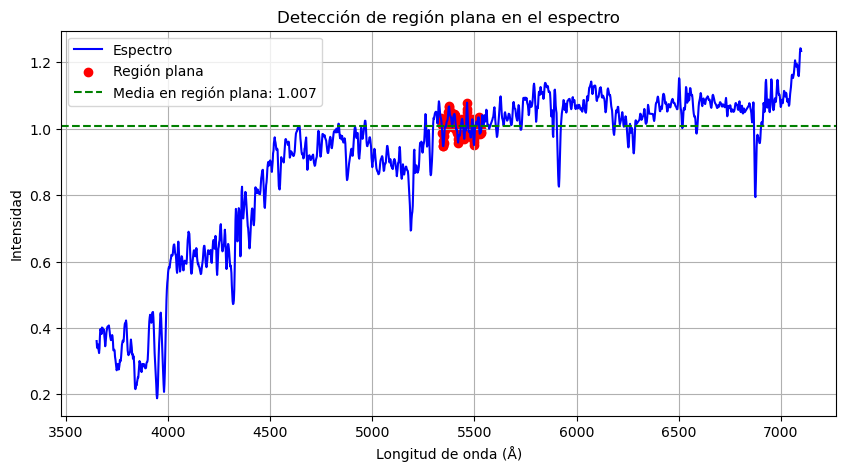

(1.0074490450000007, 0.017117263179903325)

In [4]:
detectar_region_plana_grafica(archivo='NGC_3379.txt',ventana=100, suavizado=10)

# Código de sonificación donde ocurre la magia

Este código sonifica una región del espectro dada en el parámetro rango_onda, toma el espectro total y extrae la región dada para realizar el proceso de sonificación. En este caso la sonificación se realiza según la amplitud del espectro en cierta longitud de onda, se otorgan notas según sea el valor de amplitud.

## Conversión del espectro en sonido
Primeramente se define una escala musical, en este caso se trata de la escala Am pentatónica (La menor pentatónica) porque las escalas pentatónicas tienen la particularidad de no involucrar tritonos u otros intervalos musicales que pueden generar disonancias. También se escoge la cantidad de octavas con el código y se nombran las notas con el código

        # Definir la escala pentatónica con nombres de notas
        pentatonic_scale = [("A", 69), ("C", 72), ("D", 74), ("E", 76), ("G", 79)]
        octaves = [-24, -12, 0, 12, 24, 36, 48]  # 7 octavas desde -2 hasta +4
        full_scale = [(name, note + octave) for octave in octaves for name, note in pentatonic_scale]

La siguiente parte del código defina cada cuánto cambiarán las notas según la amplitud máxima (en el caso de las galaxias espirales se optó por tomar la amplitud máxima como 8 ya que en el catálogo de galaxias que se están sonorizando la línea $H_\alpha$ tiene un máximo de aproximadamente 7 en una de las galaxias, para implementar esto en el código solo sería necesario cambiar el valor max_intensitie por 8. step_size define cuánto debe aumentar la intensidad para pasar a la siguiente nota.

        # Definir step_size basado en el rango de intensidades
    num_notes = len(full_scale)
    step_size = (max_intensity - min_intensity) / num_notes  # Ajustar según el rango de amplitudes

La emisión y la absorción se identifica según la media calculada con el código anterior, para valores mayores a esa media se les asigna emición y para valores menores se les asigna absorción. Los valores de amplitudes asociados con emisión se sonifican con notas agudas mientras la absorción con notas graves. Se define entonces la escala en orden ascendente en la dirección donde aumenta la amplitud

El codigo separa ambas líneas y guarda la sonificación en dos archivos .MIDI, uno para absorción y otro para emisión con la idea de darles instrumentos musicales diferenes para apreciar mejor la naturaleza de cada línea, esto se puede hacer con un DAW como Reaper por ejemplo.

A las notas se les asigna un tempo en BPM (cada cuanto se reproducen las notas en el archivo MIDI) y una duración que indica durante cuánto tiempo sonará esa nota, se tiene por defecto en 0.5 segundos. Para que ambos archivos de emición y absorción estén sincronizados se utiliza la duración de la nota y su posición, lo que hace que por ejemplo si ocurre emisión en el archivo MIDI de emisión se agrega una nota y en el archivo MIDI de absorción se agrega un silencio.

## Graficación
Se mapean las notas con colores ya que al tener varias octavas la misma nota se repetirá en varias ocasiones, los colores ayudan de forma visual a identificar que se trata de la misma nota solo que más aguda o más grave según su posición. Se utilizan la media y la desviación encontradas anteriormente para identificar desde donde se toma la emición y desde donde la absorción y en la primera gráfica se muestra en amarillo la región a sonorizar y en la segunda gráfica el mapa de notas sobre el espectro, puntos de un color que indican emisión y puntos de otro color que indcan absorción

In [5]:
def sonificar_espirales(archivo, rango_onda=(6500, 6700), tempo=200, duracion_nota=0.5,
                        salida_midi_emision="salida_emision.mid", salida_midi_absorcion="salida_absorcion.mid",
                        ventana=100, suavizado=10, rango_central=(0.95, 1.05)):
    # Cargar datos
    with open(archivo, 'r') as f:
        primera_linea = f.readline().strip()
    
    # Detectar si hay encabezado
    try:
        [float(x) for x in primera_linea.split()]
        skip = 0  # No es encabezado
    except ValueError:
        skip = 1  # Es encabezado

    # Intentar leer con diferentes separadores
    try:
        datos = pd.read_csv(archivo, sep=r"\s+", comment='#', header=None, skiprows=skip, dtype={0: float, 1: float})
    except:
        datos = pd.read_csv(archivo, sep=';', comment='#', header=None, skiprows=skip, dtype={0: float, 1: float})
    
    # Extraer longitudes de onda e intensidades
    todas_wavelengths = datos.iloc[:, 0].values
    todas_intensities = datos.iloc[:, 1].values
    
    # Filtrar la región de interés
    mask = (datos.iloc[:, 0] >= rango_onda[0]) & (datos.iloc[:, 0] <= rango_onda[1])
    wavelengths = datos.iloc[:, 0][mask].values
    intensities = datos.iloc[:, 1][mask].values
    
    # Calcular estadísticas
    #mean_intensity = np.mean(todas_intensities)
    #std_intensity = np.std(todas_intensities)

        # Detectar la media y desviación en una región plana
    mean_intensity, std_intensity = detectar_region_plana(archivo, ventana, suavizado, rango_central)

    if mean_intensity is None or std_intensity is None:
        print("No se puede continuar con la sonificación sin una región plana válida.")
        return
        
    min_intensity = np.min(todas_intensities)
    max_intensity = np.max(todas_intensities)

    archivo_nombre = os.path.splitext(os.path.basename(archivo))[0]
    
    # Definir la escala pentatónica con nombres de notas
    pentatonic_scale = [("A", 69), ("C", 72), ("D", 74), ("E", 76), ("G", 79)]
    octaves = [-24, -12, 0, 12, 24, 36, 48]  # 7 octavas desde -2 hasta +4
    full_scale = [(name, note + octave) for octave in octaves for name, note in pentatonic_scale]
    
    # Definir step_size basado en el rango de intensidades
    num_notes = len(full_scale)
    step_size = (max_intensity - min_intensity) / num_notes  # Ajustar según el rango de amplitudes
    
    # Crear archivos MIDI para emisión y absorción
    midi_emision = MIDIFile(1)
    midi_emision.addTempo(0, 0, tempo)
    
    midi_absorcion = MIDIFile(1)
    midi_absorcion.addTempo(0, 0, tempo)
    
    for i, intensity in enumerate(intensities):
        tiempo = i * duracion_nota  # Asegurar que ambos MIDI estén sincronizados
        
        index = int((intensity - min_intensity) / step_size)
        index = max(0, min(index, num_notes - 1))  # Asegurar índice válido
        note_name, note = full_scale[index]
        
        if intensity > mean_intensity:  # Emisión
            midi_emision.addNote(0, 0, note, tiempo, duracion_nota, 100)
        else:  # Absorción
            midi_absorcion.addNote(0, 0, note, tiempo, duracion_nota, 100)
    
    # Guardar archivos MIDI
    with open(salida_midi_emision, "wb") as output_file:
        midi_emision.writeFile(output_file)
    print(f"Archivo MIDI de emisión guardado como '{salida_midi_emision}'")
    
    with open(salida_midi_absorcion, "wb") as output_file:
        midi_absorcion.writeFile(output_file)
    print(f"Archivo MIDI de absorción guardado como '{salida_midi_absorcion}'")
    

    # Mapeo de colores para cada nota
    note_colors = {
        "A": "blue",
        "C": "green",
        "D": "orange",
        "E": "purple",
        "G": "red"
    }

    fig, axs = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1]})
    
    # --- PRIMER GRÁFICO: Espectro completo con la región resaltada ---
    axs[0].plot(todas_wavelengths, todas_intensities, color="gray", alpha=0.7, label="Espectro completo")
    axs[0].axvspan(rango_onda[0], rango_onda[1], color='yellow', alpha=0.3, label="Región sonificada")
    
    # Líneas de referencia
    axs[0].axhline(y=mean_intensity, color="black", linestyle="-", linewidth=1.5, label="Media de intensidades")
    axs[0].axhline(y=mean_intensity + 1*std_intensity, color="green", linestyle="-", linewidth=1.5)
    axs[0].axhline(y=mean_intensity - 1*std_intensity, color="red", linestyle="-", linewidth=1.5)
    
    axs[0].set_xlabel("Longitud de onda (Å)")
    axs[0].set_ylabel("Intensidad normalizada")
    axs[0].set_title(f"Espectro completo {archivo_nombre}")
    axs[0].legend()
    axs[0].grid()
    
    # --- SEGUNDO GRÁFICO: Región sonorizada con líneas de colores ---
    horizontal_lines = [min_intensity + i * step_size for i in range(num_notes)]
    
    axs[1].plot(wavelengths, intensities, label=f"Espectro normalizado {archivo_nombre}", color="blue")

    # Separar puntos de absorción y emisión
    absorcion_mask = intensities < 1
    emision_mask = intensities > 1
    
    axs[1].scatter(wavelengths[absorcion_mask], intensities[absorcion_mask], color="blue", s=20, label="Absorción (Azul)", zorder=3)
    axs[1].scatter(wavelengths[emision_mask], intensities[emision_mask], color="red", s=20, label="Emisión (Rojo)", zorder=3)
 
    
    # Agregar líneas de colores para cada nota
    for i, pos in enumerate(horizontal_lines):
        note_name, _ = full_scale[i]
        color = note_colors[note_name]  # Seleccionar color basado en la nota
        
        axs[1].axhline(y=pos, linestyle='--', color=color, alpha=0.7, linewidth=1)
        axs[1].text(max(wavelengths) + 5, pos, note_name, color=color, fontsize=10, verticalalignment='center')
    
    # Líneas de referencia
    axs[1].axhline(y=mean_intensity, color="black", linestyle="-", linewidth=1.5, label="Media de intensidades")
    axs[1].axhline(y=mean_intensity + 1*std_intensity, color="green", linestyle="-", linewidth=1.5)
    axs[1].axhline(y=mean_intensity - 1*std_intensity, color="red", linestyle="-", linewidth=1.5)
    
    axs[1].set_title("Sonorización del espectro con escala pentatónica")
    axs[1].set_xlabel("Longitud de onda (Å)")
    axs[1].set_ylabel("Intensidad normalizada")
    axs[1].grid(True)
    axs[1].legend(loc="upper left")
    axs[1].set_xlim([min(wavelengths), max(wavelengths) + 50])  # Espacio extra para la leyenda
    
    plt.tight_layout()  # Ajustar diseño para evitar solapamientos
    plt.show()

Archivo MIDI de emisión guardado como 'Emision_H_alpha_NGC_6643.mid'
Archivo MIDI de absorción guardado como 'Absorción_H_alpha_NGC_6643.mid'


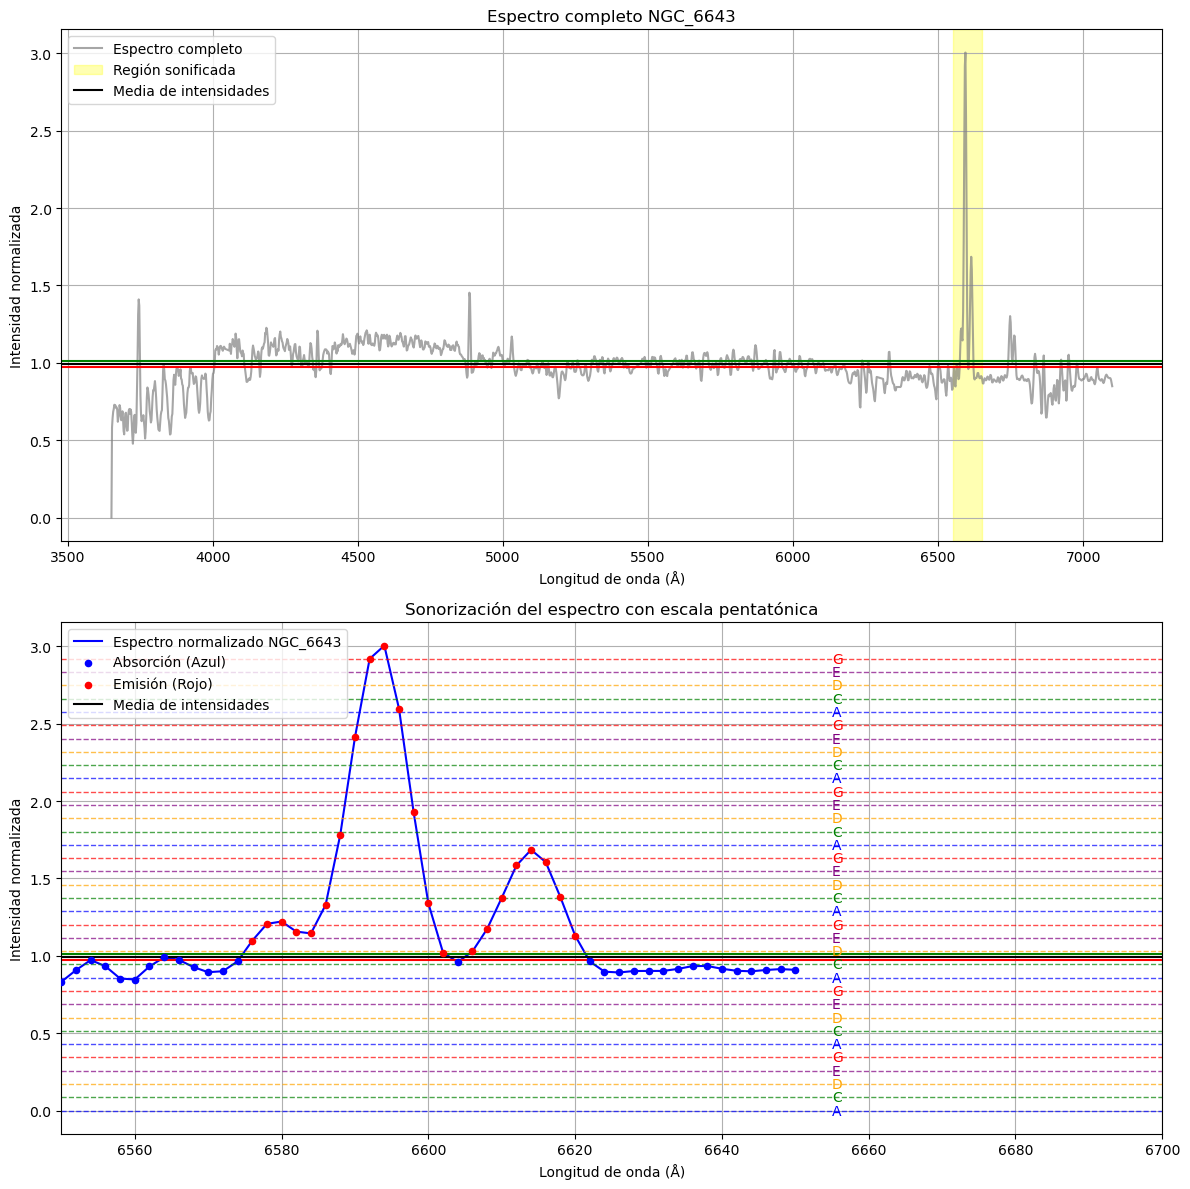

In [6]:
sonificar_espirales(archivo='NGC_6643.txt',salida_midi_emision= 'Emision_H_alpha_NGC_6643.mid',
                    salida_midi_absorcion = 'Absorción_H_alpha_NGC_6643.mid', rango_onda=(6550, 6650))

Archivo MIDI de emisión guardado como 'Emision_G_band_NGC_6643.mid'
Archivo MIDI de absorción guardado como 'Absorción_G_band_NGC_6643.mid'


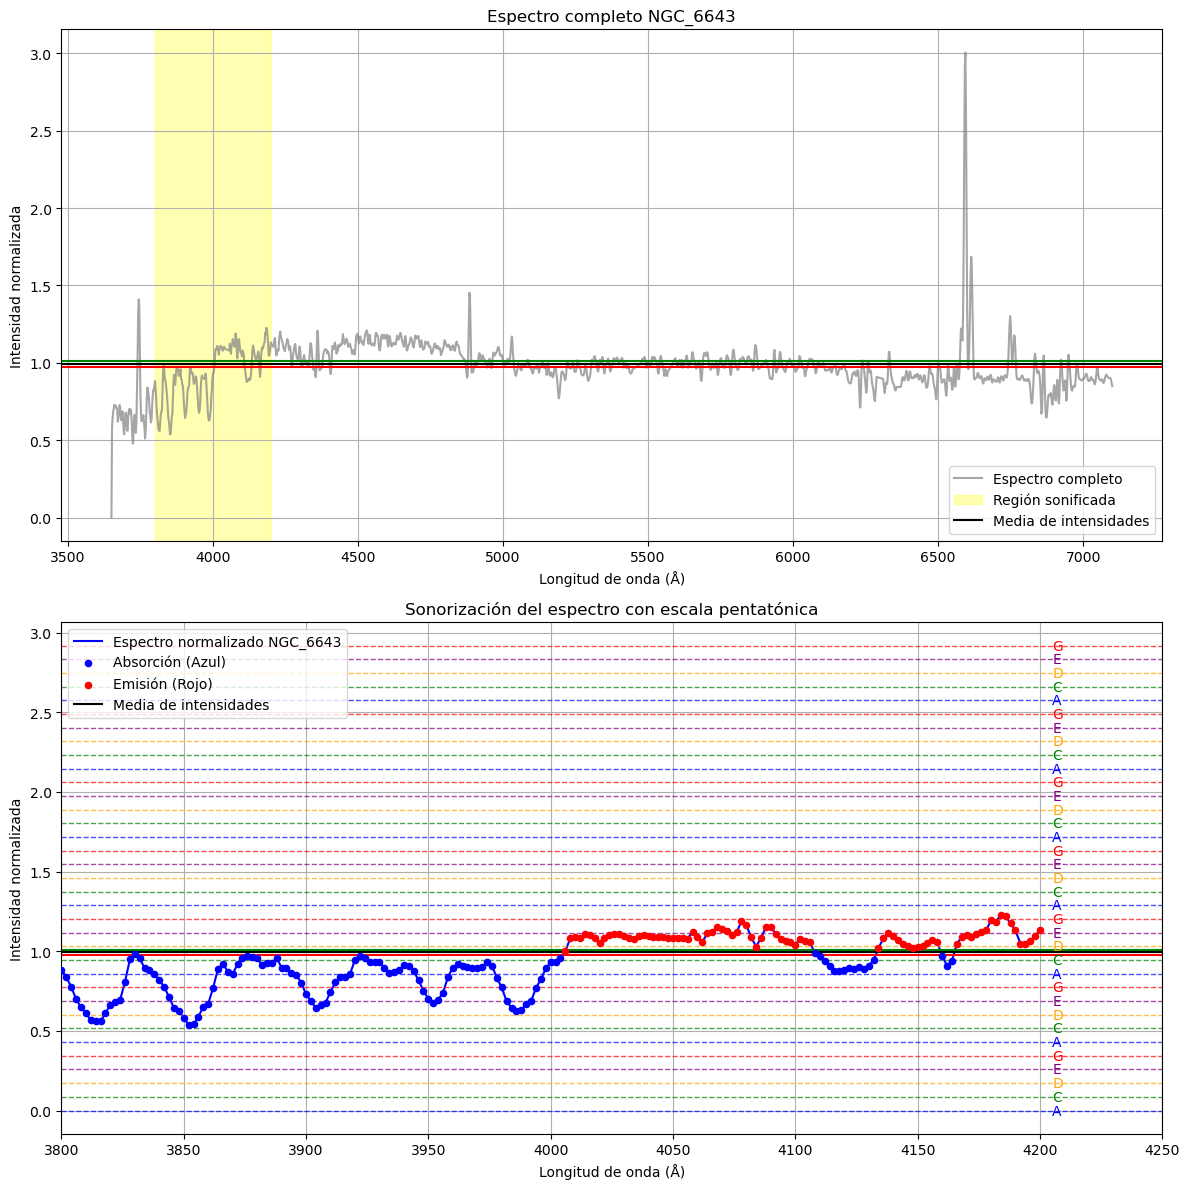

In [7]:
sonificar_espirales(archivo='NGC_6643.txt',salida_midi_emision= 'Emision_G_band_NGC_6643.mid',
                    salida_midi_absorcion = 'Absorción_G_band_NGC_6643.mid', rango_onda=(3800, 4200))

In [8]:
#sonificar_espirales(archivo='NGC_2276.txt',salida_midi_emision= 'EmisionH_alpha_NGC_2276.mid',
#                    salida_midi_absorcion = 'AbsorciónH_alpha_NGC_2276.mid', rango_onda=(6550, 6700))

In [9]:
#sonificar_espirales(archivo='NGC_2276.txt',salida_midi_emision= 'EmisionH_G_Band_NGC_2276.mid',
#                    salida_midi_absorcion = 'Absorción_G_Band_NGC_2276.mid', rango_onda=(3800, 4200))

# Galaxias Elípticas

En el caso de las elípticas el código funciona exactamente igual al de las espirales, solo que esta vez el rango de amplitudes cambia, lo que implica que no se pueden comparar justamente elípticas con espirales pues por los rangos de cambios de nota que da la variable step_size los cambios de notas no alcanzan a identificar las líneas en el espectro de la galaxia elíptica, por lo que se hace necesario cambiar el valor de amplitid máxima ya que en el catálogo escogido las galaxias elípticas no alcanzan a llegar a un valor de amplitud de 2

In [10]:
def sonificar_elipticas(archivo, rango_onda=(6500, 6700), tempo=200, duracion_nota=0.5,
                        salida_midi_emision="elipticas_emision.mid", salida_midi_absorcion="elipticas_absorcion.mid",
                        ventana=100, suavizado=10, rango_central=(0.95, 1.05)):
    # Cargar datos
    with open(archivo, 'r') as f:
        primera_linea = f.readline().strip()
    
    # Detectar si hay encabezado
    try:
        [float(x) for x in primera_linea.split()]
        skip = 0  # No es encabezado
    except ValueError:
        skip = 1  # Es encabezado

    # Intentar leer con diferentes separadores
    try:
        datos = pd.read_csv(archivo, sep=r"\s+", comment='#', header=None, skiprows=skip, dtype={0: float, 1: float})
    except:
        datos = pd.read_csv(archivo, sep=';', comment='#', header=None, skiprows=skip, dtype={0: float, 1: float})
    
    # Extraer longitudes de onda e intensidades
    todas_wavelengths = datos.iloc[:, 0].values
    todas_intensities = datos.iloc[:, 1].values
    
    # Filtrar la región de interés
    mask = (datos.iloc[:, 0] >= rango_onda[0]) & (datos.iloc[:, 0] <= rango_onda[1])
    wavelengths = datos.iloc[:, 0][mask].values
    intensities = datos.iloc[:, 1][mask].values

        # Detectar la media y desviación en una región plana
    mean_intensity, std_intensity = detectar_region_plana(archivo, ventana, suavizado, rango_central)

    if mean_intensity is None or std_intensity is None:
        print("No se puede continuar con la sonificación sin una región plana válida.")
        return
    
    min_intensity = np.min(todas_intensities)
    max_intensity = np.max(todas_intensities)

    archivo_nombre = os.path.splitext(os.path.basename(archivo))[0]
    
    # Definir la escala pentatónica con nombres de notas
    pentatonic_scale = [("A", 69), ("C", 72), ("D", 74), ("E", 76), ("G", 79)]
    octaves = [-24, -12, 0, 12, 24, 36]  # 6 octavas desde -2 hasta +3
    
    # Expandir la escala a múltiples octavas con nombres
    full_scale = [(name, note + octave) for octave in octaves for name, note in pentatonic_scale]
    num_notes = len(full_scale)
    step_size = 1.05 / num_notes  # Ajustar según el rango de amplitudes (0 a 2)
    
    # Crear archivos MIDI separados para emisión y absorción
    midi_emision = MIDIFile(1)
    midi_absorcion = MIDIFile(1)
    midi_emision.addTempo(0, 0, tempo)
    midi_absorcion.addTempo(0, 0, tempo)
    
    puntos_sonificados = []
    
    for i, intensity in enumerate(intensities):
        index = int((intensity - min_intensity) / step_size)
        index = max(0, min(index, num_notes - 1))  # Asegurar índice válido
        note_name, note = full_scale[index]
        
        if intensity >= 1:  # Emisión
            midi_emision.addNote(0, 0, note + 12, i * duracion_nota, duracion_nota, 100)  # Octava más alta
        else:  # Absorción
            midi_absorcion.addNote(0, 0, note - 12, i * duracion_nota, duracion_nota, 100)  # Octava más baja
        
        puntos_sonificados.append((wavelengths[i], intensity))
    
    # Guardar archivos MIDI
    with open(salida_midi_emision, "wb") as output_file:
        midi_emision.writeFile(output_file)
    with open(salida_midi_absorcion, "wb") as output_file:
        midi_absorcion.writeFile(output_file)
    
    print(f"Archivos MIDI guardados como '{salida_midi_emision}' y '{salida_midi_absorcion}'")
    
    # Mapeo de colores para cada nota
    note_colors = {
        "A": "blue",
        "C": "green",
        "D": "orange",
        "E": "purple",
        "G": "red"
    }

    fig, axs = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1]})
    
    # --- PRIMER GRÁFICO: Espectro completo con la región resaltada ---
    axs[0].plot(todas_wavelengths, todas_intensities, color="gray", alpha=0.7, label="Espectro completo")
    axs[0].axvspan(rango_onda[0], rango_onda[1], color='yellow', alpha=0.3, label="Región sonificada")
    
    # Líneas de referencia
    axs[0].axhline(y=mean_intensity, color="black", linestyle="-", linewidth=1.5, label="Media de intensidades")
    axs[0].axhline(y=mean_intensity + 1*std_intensity, color="green", linestyle="-", linewidth=1.5)
    axs[0].axhline(y=mean_intensity - 1*std_intensity, color="red", linestyle="-", linewidth=1.5)
    
    axs[0].set_xlabel("Longitud de onda (Å)")
    axs[0].set_ylabel("Intensidad normalizada")
    axs[0].set_title(f"Espectro completo {archivo_nombre}")
    axs[0].legend()
    axs[0].grid()
    
    # --- SEGUNDO GRÁFICO: Región sonorizada con líneas de colores ---
    horizontal_lines = [min_intensity + i * step_size for i in range(num_notes)]
    
    axs[1].plot(wavelengths, intensities, label=f"Espectro normalizado {archivo_nombre}", color="blue")
    
    # Separar puntos de absorción y emisión
    absorcion_mask = intensities < 1
    emision_mask = intensities > 1
    
    axs[1].scatter(wavelengths[absorcion_mask], intensities[absorcion_mask], color="blue", s=20, label="Absorción (Azul)", zorder=3)
    axs[1].scatter(wavelengths[emision_mask], intensities[emision_mask], color="red", s=20, label="Emisión (Rojo)", zorder=3)

    
    # Agregar líneas de colores para cada nota
    for i, pos in enumerate(horizontal_lines):
        note_name, _ = full_scale[i]
        color = note_colors[note_name]  # Seleccionar color basado en la nota
        
        axs[1].axhline(y=pos, linestyle='--', color=color, alpha=0.7, linewidth=1)
        axs[1].text(max(wavelengths) + 5, pos, note_name, color=color, fontsize=10, verticalalignment='center')
    
    # Líneas de referencia
    axs[1].axhline(y=mean_intensity, color="black", linestyle="-", linewidth=1.5, label="Media de intensidades")
    axs[1].axhline(y=mean_intensity + 1*std_intensity, color="green", linestyle="-", linewidth=1.5)
    axs[1].axhline(y=mean_intensity - 1*std_intensity, color="red", linestyle="-", linewidth=1.5)
    
    axs[1].set_title("Sonorización del espectro con escala pentatónica")
    axs[1].set_xlabel("Longitud de onda (Å)")
    axs[1].set_ylabel("Intensidad normalizada")
    axs[1].grid(True)
    axs[1].legend(loc="upper left")
    axs[1].set_xlim([min(wavelengths), max(wavelengths) + 50])  # Espacio extra para la leyenda
    
    plt.tight_layout()  # Ajustar diseño para evitar solapamientos
    plt.show()

Archivos MIDI guardados como 'Emision_H_alpha_NGC_3379.mid' y 'Absorción_H_alpha_NGC_3379.mid'


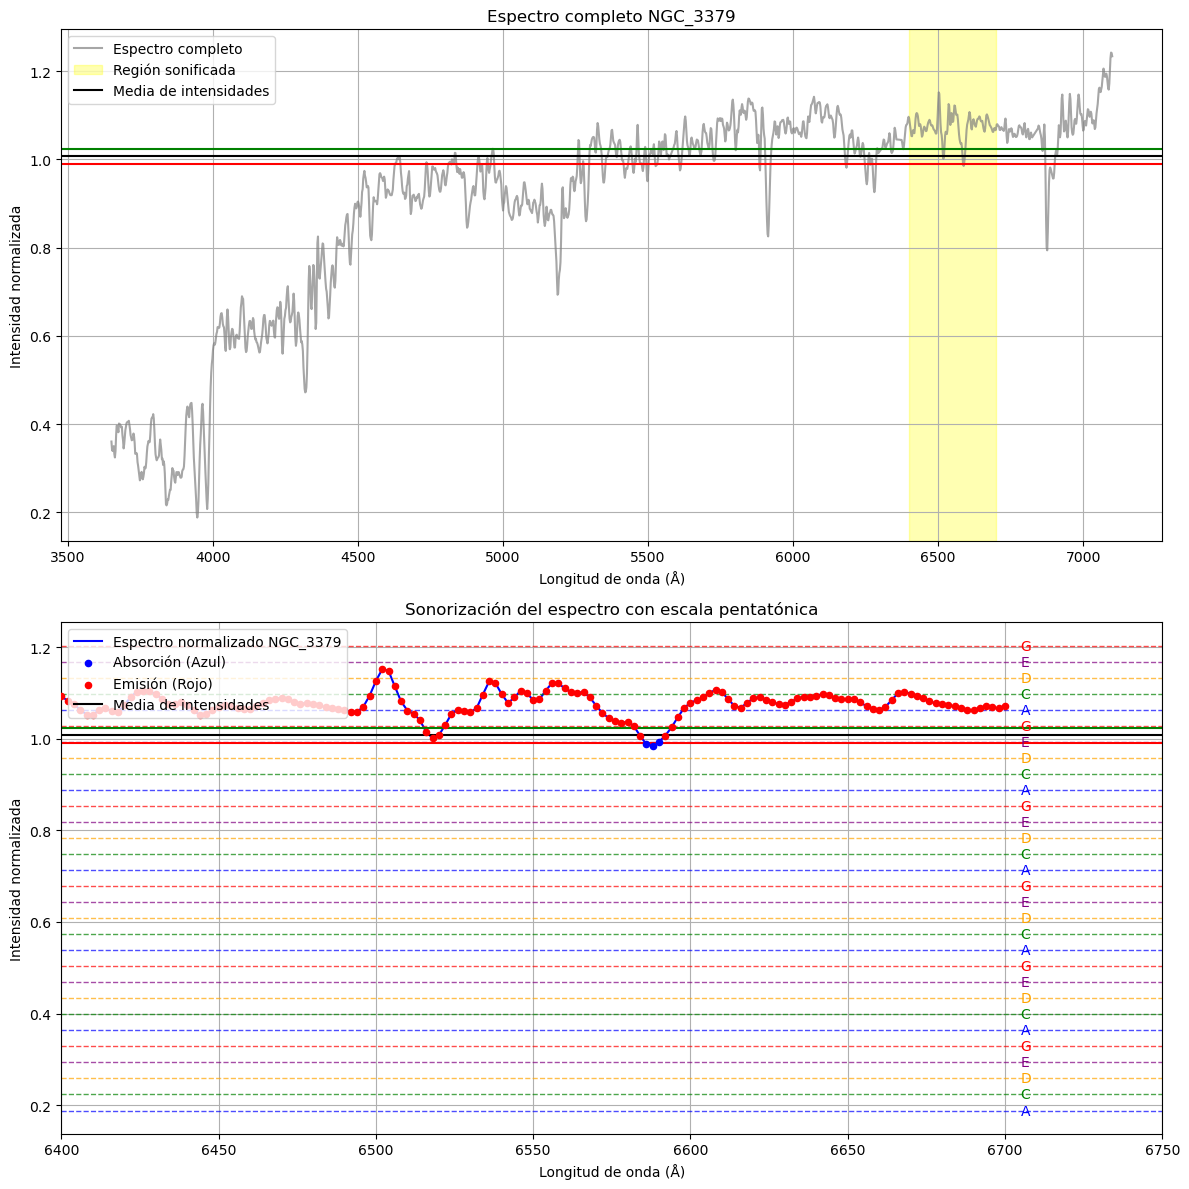

In [11]:
sonificar_elipticas(archivo='NGC_3379.txt',salida_midi_emision= 'Emision_H_alpha_NGC_3379.mid',
                    salida_midi_absorcion = 'Absorción_H_alpha_NGC_3379.mid', rango_onda=(6400, 6700))

Archivos MIDI guardados como 'Emision_G_Band_NGC_3379.mid' y 'Absorción_G_Band_NGC_3379.mid'


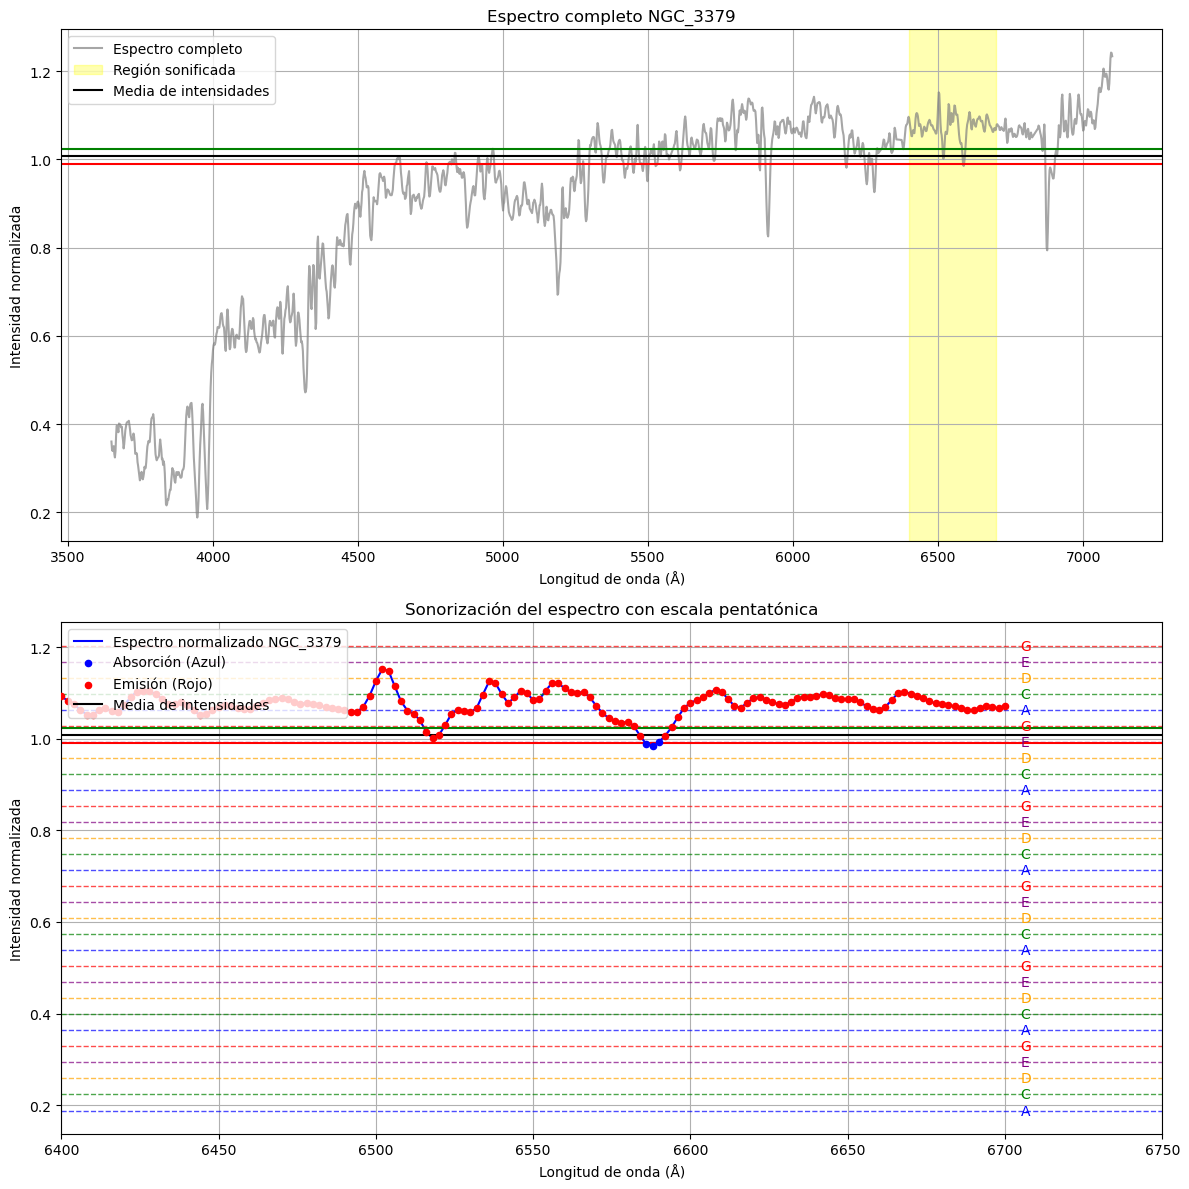

In [12]:
sonificar_elipticas(archivo='NGC_3379.txt',salida_midi_emision= 'Emision_G_Band_NGC_3379.mid',
                    salida_midi_absorcion = 'Absorción_G_Band_NGC_3379.mid', rango_onda=(6400, 6700))

In [13]:
#sonificar_elipticas(archivo='NGC_3379.txt',salida_midi_emision= 'Emision_G_Band_NGC_3379.mid',
#                    salida_midi_absorcion = 'Absorción_G_Band_NGC_3379.mid', rango_onda=(6400, 6700))

In [14]:
#sonificar_elipticas(archivo='NGC_4648.txt',salida_midi_emision= 'Emision_G_Band_NGC_4648.mid',
#                    salida_midi_absorcion = 'Absorción_G_Band_NGC_4648.mid', rango_onda=(3800, 4200))

# Intento de identificar la galaxia según datos del espectro

Se intenta identificar galaxias según la media, si la media es mayor a 1 (galaxia más que todo de emisión) se define como espital, si es menor a 1 se eligr como elíptica, sin embargo no funciona del todo bien ya que algunas espirales pueden tener menos emisión

In [15]:
def tipo(archivo, rango_onda=(3800, 4200)):
    # Cargar datos
    datos = pd.read_csv(archivo, sep=';')
    
    # Filtrar datos dentro del rango de longitud de onda
    mask = (datos.iloc[:, 0] >= rango_onda[0]) & (datos.iloc[:, 0] <= rango_onda[1])
    wavelengths = datos.iloc[:, 0][mask].values
    intensities = datos.iloc[:, 1][mask].values

    media = np.mean(intensities)

    if media>2:
        tipo = "Irregular"
    if media <2 and media>1:
        tipo = "Espiral"
    if media<1:
        tipo = "Eliptica"


    print(f"Galaxia es {tipo}, con media {media}")
    return(tipo)
        

In [16]:
tipo(archivo='NGC_4648.txt')
tipo(archivo='NGC_3379.txt')
tipo(archivo='NGC_6643.txt')
tipo(archivo='NGC_2276.txt')

Galaxia es Eliptica, con media 0.4575776965174129
Galaxia es Eliptica, con media 0.46820108955223877
Galaxia es Eliptica, con media 0.9322795472636815
Galaxia es Espiral, con media 1.1287197860696518


'Espiral'